# 基于LLM的企业年报信息自动化抽取系统

## 项目简介
本项目使用智谱AI GLM-4模型从中国石油年报中自动提取非洲业务相关的结构化商业信息。

## 核心功能
1. **文本预处理**: 长文档分句、文本清洗
2. **LLM信息抽取**: 使用Prompt引导模型提取5维度商业信息（业务名称/业务方/时间/标的物/金额）
3. **结构化输出**: JSON解析并转换为DataFrame
4. **数据导出**: 自动生成Excel报表
5. **效果验证**: TF-IDF+KMeans聚类分析

## 使用前准备
1. 安装依赖: `pip install -r requirements.txt`
2. 配置API Key: 复制`.env.example`为`.env`，填入你的智谱AI API Key
3. 按顺序运行各个cell

---

In [67]:
# 导入必要的库

'''来自Python标准库'''

import os
import re
import json
import string
import pickle
from pathlib import Path

'''来自第三方库'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jieba

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment

# 初始化API客户端
from zhipuai import ZhipuAI
# 从环境变量加载API Key（安全做法）
from dotenv import load_dotenv
load_dotenv()

client = ZhipuAI(api_key=os.getenv("ZHIPU_API_KEY"))
message, all_data= [], []


<h1>Utils<h1>

In [68]:
def show_json_output(response):
    """Json格式整理函数，直接输入response"""
    output = response.choices[0].message.content
    print("Raw output:", output)  # 打印原始输出
    try:
        output = output.replace("```json", "").replace("```", "")
        # print("Processed output:", output)  # 打印处理后的输出
        output = json.loads(output)
        if type(output) != list:
            output = [output]
        return output
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError: {e}")
        print("Failed to decode JSON. Here's the problematic part:")
        print(output[max(0, e.pos - 50):e.pos + 50])  # 打印错误附近的内容
        return output

def clean_text(text):
    """清理文本中的多余换行符，合并被错误分割的句子"""
    # 合并单个换行符为无空格，保持双换行作为段落分隔
    cleaned = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)
    cleaned = re.sub(r'\n\n', '\n\n', cleaned)  # 确保段落间有一个空行
    return cleaned

def split_into_sentences(text, max_length=512):
    """将文本按句子分割，并保证每个句子不超过最大长度，默认最大长度512"""
    sentences = []
    for paragraph in text.split('\n\n'):
        # 按句号分割段落中的句子
        for sentence in re.split(r'(?<=[。！？])\s*', paragraph.strip()):
            if sentence:
                # 如果句子太长，尝试按逗号进一步分割
                if len(sentence) > max_length:
                    sub_sentences = re.split(r'(?<=，)\s*', sentence)
                    current_sentence = ''
                    for sub_sent in sub_sentences:
                        if len(current_sentence) + len(sub_sent) + 1 <= max_length:
                            current_sentence += sub_sent + '，'
                        else:
                            if current_sentence:
                                sentences.append(current_sentence.rstrip('，'))
                            current_sentence = sub_sent + '，'
                    if current_sentence:
                        sentences.append(current_sentence.rstrip('，'))
                else:
                    sentences.append(sentence)
    return sentences

def load_from_pickle(file_path):
    """从.pkl文件加载数据"""
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: The file {file_path} does not exist.")
        return None
    except pickle.UnpicklingError:
        print(f"Error: Failed to unpickle the file {file_path}. It may not be a valid pickle file.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def save_to_pickle(data, output_file_path):
    """将数据保存为.pkl文件"""
    try:
        with open(output_file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"Data has been saved to {output_file_path}")
    except Exception as e:
        print(f"Failed to save data to {output_file_path}: {e}")


def remove_duplicates_and_save(input_file_path, output_file_path):
    """读取pkl文件中的列表，去除重复项，并保存到新的pkl文件"""
    # 加载列表
    original_list = load_from_pickle(input_file_path)
    if original_list is None:
        print("Failed to load the list. Exiting.")
        return
    unique_set = set(original_list)  # 去重（使用集合去除重复项）
    unique_list = list(dict.fromkeys(original_list))  # 将集合转换回列表（按原顺序）
    # 打印去重前后的长度对比
    print(f"Original list length: {len(original_list)}")
    print(f"Unique list length: {len(unique_list)}")
    # 保存去重后的列表到新的pkl文件
    save_to_pickle(unique_list, output_file_path)

def load_stopwords(file_path):
    """加载停用词表"""
    with open(file_path, 'r', encoding='utf-8') as f:
        stopwords = set(line.strip() for line in f)
    return list(stopwords)  # 确保返回的是列表

def preprocess_texts(texts, stopwords_path):
    """中文文本预处理函数"""
    with open(stopwords_path, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    processed_texts = []
    for text in texts:
        # 去除数字和特殊字符（保留汉字）
        text = re.sub(r'[^\u4e00-\u9fff]+', ' ', text)
        words = jieba.lcut(text)  # 分词
        # 去除停用词
        words = [word for word in words if word not in stop_words]
        processed_texts.append(' '.join(words))  # 将分词结果连接成字符串
    return processed_texts

def save_dataframe_to_excel(df, output_file):
    """保存DataFrame为Excel文件，并自动调整列宽，设置行高和对齐方式"""
    wb = Workbook()
    ws = wb.active
    # 设置行高为默认的13.5
    default_row_height = 13.5
    for row in ws.iter_rows():
        ws.row_dimensions[row[0].row].height = default_row_height
    # 将 DataFrame 写入工作表
    for r in dataframe_to_rows(df, index=False, header=True):
        ws.append(r)
    # 自动调整列宽
    for column in ws.columns:
        max_length = 28
        column_letter = column[0].column_letter  # 获取列字母标识符
        for cell in column:
            max_length = len(str(cell.value))
        adjusted_width = (max_length + 2)  # 添加一些额外空间以提高可读性
        ws.column_dimensions[column_letter].width = adjusted_width
    # 设置文本对齐方式（竖直方向居中，水平方向左对齐）
    for row in ws.iter_rows():
        for cell in row:
            cell.alignment = Alignment(vertical='center', horizontal='left')
    # 保存工作簿到指定路径
    wb.save(output_file)
    print(f"Excel file saved to {output_file}")

<h1>转换PDF为TXT<h1>
<h4>如果已经得到了TXT文件，无需重复执行此单元格<h4>

In [ ]:
import pdfplumber
# 源文件夹路径
source_folder = r"D:\MyCodes\Logs\240929_LLMAfrica\data\PDF"
# 目标文件夹路径，用于保存TXT文件
target_folder = r"D:\MyCodes\Logs\240929_LLMAfrica\data\TXT"

# 如果目标文件夹不存在，则创建它
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# 遍历源文件夹中的所有文件
for filename in os.listdir(source_folder):
    if filename.endswith(".pdf"):
        # 构建完整的文件路径
        file_path = os.path.join(source_folder, filename)

        # 使用pdfplumber打开PDF文件
        with pdfplumber.open(file_path) as pdf:
            # 初始化一个空字符串来保存文本内容
            text = ""

            # 遍历PDF中的每一页
            for page in pdf.pages:
                # 提取页面的文本并添加到text变量中
                text += page.extract_text()
                text += "\n\n"  # 添加换行符以分隔不同页面的内容

        # 构建目标TXT文件的路径，文件名保持不变，只是扩展名改为.txt
        txt_file_path = os.path.join(target_folder, filename.replace(".pdf", ".txt"))

        # 将文本内容写入TXT文件
        with open(txt_file_path, "w", encoding="utf-8") as txt_file:
            txt_file.write(text)

        print(f"已转换文件: {filename} -> {txt_file_path}")

<h1>筛选数据<h1>
<h4>如果已经得到了初筛结果的pkl文件，无需重复执行此单元格<h4>

In [ ]:
source_folder = r"D:\MyCodes\Logs\240929_LLMAfrica\data\TXT" # 填写存放年报TXT的文件夹
output_folder = r"D:\MyCodes\Logs\240929_LLMAfrica\data\Output" # 输出列表的文件夹

# 创建输出文件夹（如果不存在）
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 存储所有文件的有效数据
all_data = []

# 遍历文件夹下所有TXT文件
for filename in os.listdir(source_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(source_folder, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()

        # 清洗、切割文本
        cleaned_content = clean_text(file_content)
        sentences = split_into_sentences(cleaned_content)

        # 构建储存单次文件有效数据的列表
        flush = []
        for s in sentences:
            # 跳过分页符
            if s.isdigit() or s.replace("-", "").replace(" ", "").isdigit():
                continue
            print(s)
            try:
                response = client.chat.completions.create(
                    model="glm-4-flash",
                    messages=[
                        {"role": "system", "content": "你是一名严格执行用户指令的数据分类助手。"},
                        {"role": "user", "content": "请判断下面这段文字是否具体涉及在非洲地区的业务活动，只有明确提到非洲或非洲某国家或企业才算相关，相关只需要回复“相关”，无关只需要回复“无关”：\n{}".format(s)}
                    ]
                )
                print(response.choices[0].message.content)
                if response.choices[0].message.content.strip().lower() == "相关":
                    flush.append(s)
                    all_data.append(s)
            except Exception as e:
                print(f"Error processing {filename}: {e}")
                continue
        
        # 对于每个文件，保存其有效数据到独立的pkl文件
        output_file_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_filtered.pkl")
        with open(output_file_path, 'wb') as f:
            pickle.dump(flush, f)

# 最终保存所有文件的有效数据
final_output_file = os.path.join(output_folder, 'all_filtered_data.pkl')
with open(final_output_file, 'wb') as f:
    pickle.dump(all_data, f)

print("All files have been processed and the filtered data has been saved.")

中国石油天然气股份有限公司 2012 年年度报告 （A 股股票代码：601857） 2013 年 3 月
无关
目 录 重要提示 ······················································································· 1 公司基本情况简介 ··········································································· 2 会计数据和财务指标摘要 ·································································· 5 股份变动及股东情况 ········································································ 8 董事长报告 ··················································································· 13 业务回顾 ······················································································ 15 管理层对财务状况和经营结果的讨论及分析 ········································ 20 重要事项 ······················································································ 31 关联交易 ······················································································ 36 公司治理 ······················································································ 45 股东权利及股东大会情况介绍··········································

In [ ]:
# 读取初筛数据进行二筛
all_filtered_data0 = load_from_pickle(r'D:\MyCodes\Logs\240929_LLMAfrica\data\Output\all_filtered_data.pkl')
all_filtered_data1 = []
for s in all_filtered_data0:
    print(s)
    try:
        response = client.chat.completions.create(
            model="glm-4-flash",
            messages=[
                {"role": "system", "content": "你是一名严格执行用户指令的数据分类助手。"},
                {"role": "user", "content": "请判断下面这段文字是否具体涉及在非洲地区的业务活动，只有明确提到非洲或非洲某国家或企业才算相关，相关只需要回复“相关”，无关只需要回复“无关”：\n{}".format(s)}
            ]
        )
        print(response.choices[0].message.content)
        if response.choices[0].message.content.strip().lower() == "相关":
            all_filtered_data1.append(s)
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

Data successfully loaded from D:\MyCodes\Logs\240929_LLMAfrica\data\Output\all_filtered_data.pkl
根据中国石油集团与本公司于 2000年3月10日签署的《避免同业竞 目前，中国石油集团拥有以下与本集团主营业务相同或相似的 争及优先交易权协议》，中国石油 业务： 集团向本公司承诺，中国石油集团 中国石油集团拥有与原油和天然气勘探与生产，以及石化和相 不会，且将促使其附属公司不会在 关石油产品的生产、储存和运输有关的境外项目。
无关
（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日公告关于收购PKZ公司 67%权益之交易，产生以下持续性关联交易，主要包括： ● 中国石油集团向本集团提供生产服务； ● 中国石油集团向本集团提供工程技术服务； ● 中国石油集团向本集团提供物资供应服务。
相关
炼化、储 运设施、加油站、运 输工具的投资及相关 业务 中石油西北联合管道 中国 62,500 有限责任公司 52.00 在中国境内从事石油 有限责任公司(a) 天然气及其产品储运 及相关技术的开发； 石油天然气管道工程 的建设及相关技术咨 询；货物与技术的进 出口业务；货物购销 业务 (a) 2012年12月，，中石油西北联合管道有限责任公司（以下简称“西北联合管道”）成立，，注册资本为625 亿元，，本公司持有52%的股权。
无关
石油 根据中国石油集团与本公司于2000年3月 集团 10日签署的《避免同业竞争及优先交易权 目前，中国石油集团拥有以下与本集团主营业务相同或相似 的业务： 协议》，中国石油集团向本公司承诺，中 中国石油集团拥有与原油和天然气勘探与生产，以及石化和 国石油集团不会，且将促使其附属公司不 相关石油产品的生产、储存和运输有关的境外项目。
相关
6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行 1999 年 12 月 23 日签订的《对外合作石油 协议权益转让合同》，中国石油集团已将其在与多家国际石油天然气公司签订的 23 份产品分成合同中的相关权利和义务作为重组的一部份转让给本公司，但不 包括与中国石油集团监管职能有关的权利和义务。
相关
炼化、储运 设施、加油站、 运输工具的投资 及相关业务 中石油

['（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日公告关于收购PKZ公司 67%权益之交易，产生以下持续性关联交易，主要包括： ● 中国石油集团向本集团提供生产服务； ● 中国石油集团向本集团提供工程技术服务； ● 中国石油集团向本集团提供物资供应服务。',
 '石油 根据中国石油集团与本公司于2000年3月 集团 10日签署的《避免同业竞争及优先交易权 目前，中国石油集团拥有以下与本集团主营业务相同或相似 的业务： 协议》，中国石油集团向本公司承诺，中 中国石油集团拥有与原油和天然气勘探与生产，以及石化和 国石油集团不会，且将促使其附属公司不 相关石油产品的生产、储存和运输有关的境外项目。',
 '6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行 1999 年 12 月 23 日签订的《对外合作石油 协议权益转让合同》，中国石油集团已将其在与多家国际石油天然气公司签订的 23 份产品分成合同中的相关权利和义务作为重组的一部份转让给本公司，但不 包括与中国石油集团监管职能有关的权利和义务。',
 '6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行1999年12月23日签订的《对外合作石油协议 权益转让合同》，中国石油集团已将其在与多家国际石油天然气公司签订的23份 产品分成合同中的相关权利和义务作为重组的一部份转让给本公司，但不包括与 中国石油集团监管职能有关的权利和义务。',
 '（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日公告关于收购PKZ公司 67%权益之交易，产生以下持续性关联交易，主要包括： ● 中国石油集团向本集团提供生产服务； ● 中国石油集团向本集团提供工程技术服务； ● 中国石油集团向本集团提供物资供应服务。',
 '2007年9月起任土库曼阿姆河天然气公司总经理。',
 '2008年12月起任 中国石油(土库曼斯坦)阿姆河天然气公司总经理。',
 '(3) 非居民用天然气价格的调整 根据国家发改委《关于理顺非居民用天然气价格的通知》（发改价格 [2015]351号），自 2015年 4月 1日起，将国内天然气存量气与增量气价格正式 并轨。',
 '6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行199

In [ ]:
#进行第三次筛选，并保存这次筛选的数据
all_filtered_data2=[]
for s in all_filtered_data1:
    print(s)
    try:
        response = client.chat.completions.create(
            model="glm-4-flash",
            messages=[
                {"role": "system", "content": "你是一名严格执行用户指令的数据分类助手。"},
                {"role": "user", "content": "请判断下面这段文字是否具体涉及在非洲地区的业务活动，只有明确提到非洲或非洲某国家或企业才算相关，相关只需要回复“相关”，无关只需要回复“无关”：\n{}".format(s)}
            ]
        )
        print(response.choices[0].message.content)
        if response.choices[0].message.content.strip().lower() == "相关":
            all_filtered_data2.append(s)
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

final_output_file = os.path.join(output_folder, 'final_filtered_data.pkl')
with open(final_output_file, 'wb') as f:
    pickle.dump(all_filtered_data2, f)

print("Final filtered data has been saved.")
# 数据去重
remove_duplicates_and_save(r'data/Output/final_filtered_data.pkl', r'data/Output/unique_data.pkl')

（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日公告关于收购PKZ公司 67%权益之交易，产生以下持续性关联交易，主要包括： ● 中国石油集团向本集团提供生产服务； ● 中国石油集团向本集团提供工程技术服务； ● 中国石油集团向本集团提供物资供应服务。
相关
石油 根据中国石油集团与本公司于2000年3月 集团 10日签署的《避免同业竞争及优先交易权 目前，中国石油集团拥有以下与本集团主营业务相同或相似 的业务： 协议》，中国石油集团向本公司承诺，中 中国石油集团拥有与原油和天然气勘探与生产，以及石化和 国石油集团不会，且将促使其附属公司不 相关石油产品的生产、储存和运输有关的境外项目。
无关
6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行 1999 年 12 月 23 日签订的《对外合作石油 协议权益转让合同》，中国石油集团已将其在与多家国际石油天然气公司签订的 23 份产品分成合同中的相关权利和义务作为重组的一部份转让给本公司，但不 包括与中国石油集团监管职能有关的权利和义务。
无关
6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行1999年12月23日签订的《对外合作石油协议 权益转让合同》，中国石油集团已将其在与多家国际石油天然气公司签订的23份 产品分成合同中的相关权利和义务作为重组的一部份转让给本公司，但不包括与 中国石油集团监管职能有关的权利和义务。
无关
（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日公告关于收购PKZ公司 67%权益之交易，产生以下持续性关联交易，主要包括： ● 中国石油集团向本集团提供生产服务； ● 中国石油集团向本集团提供工程技术服务； ● 中国石油集团向本集团提供物资供应服务。
相关
2007年9月起任土库曼阿姆河天然气公司总经理。
相关
2008年12月起任 中国石油(土库曼斯坦)阿姆河天然气公司总经理。
相关
(3) 非居民用天然气价格的调整 根据国家发改委《关于理顺非居民用天然气价格的通知》（发改价格 [2015]351号），自 2015年 4月 1日起，将国内天然气存量气与增量气价格正式 并轨。
无关
6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行1999年12月23日签订

<h1>对筛选后的文本进行非监督聚类<h1>

Data successfully loaded from data/Output/unique_data.pkl
Feature matrix shape: (63, 381)
For n_clusters = 2, the average silhouette_score is : 0.06056216156507392
For n_clusters = 3, the average silhouette_score is : 0.0452679047247512
For n_clusters = 4, the average silhouette_score is : 0.08730536486164421
For n_clusters = 5, the average silhouette_score is : 0.1185642949043883
For n_clusters = 6, the average silhouette_score is : 0.13777371092683147
For n_clusters = 7, the average silhouette_score is : 0.13176011465935403
For n_clusters = 8, the average silhouette_score is : 0.1893813420291318
For n_clusters = 9, the average silhouette_score is : 0.21865602495712091
For n_clusters = 10, the average silhouette_score is : 0.23654519049465686


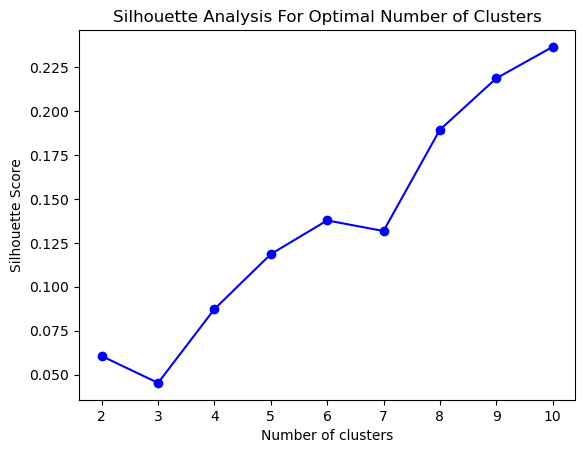

The optimal number of clusters is: 10


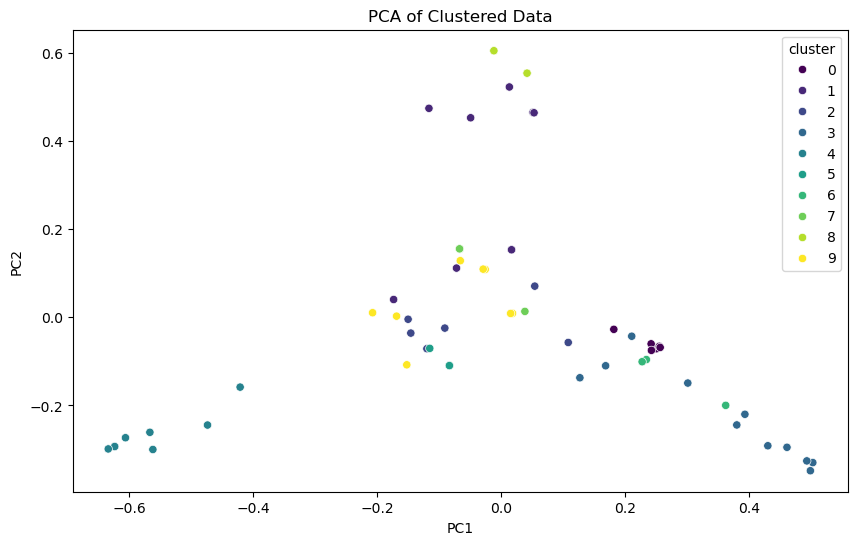

Clustering results saved to clustering_results_with_labels.csv


In [ ]:
# 文本预处理
texts = load_from_pickle(r'data/Output/unique_data.pkl')
processed_texts = preprocess_texts(texts, r'D:\MyCodes\Logs\240929_LLMAfrica\data\cn_stopwords.txt')

# 加载停用词表
stopwords_list = load_stopwords(r'D:\MyCodes\Logs\240929_LLMAfrica\data\cn_stopwords.txt')

# 使用TF-IDF创建特征矩阵，并使用自定义的中文停用词表
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stopwords_list)
X = vectorizer.fit_transform(processed_texts)
print("Feature matrix shape:", X.shape)

# 计算不同簇数下的轮廓系数
silhouette_scores = []
range_n_clusters = range(2, 11)  # 尝试从2到10个簇

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

# 绘制轮廓系数变化图
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal Number of Clusters')
plt.show()

# 确定最佳簇数（可以手动选择，也可以通过代码自动选择）
best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {best_k}")

# 使用最佳簇数进行聚类
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X)

# 将聚类结果添加到原始数据中
df = pd.DataFrame({'text': texts, 'cluster': clusters})
# 按聚类结果升序排列数据框
df_sorted = df.sort_values(by='cluster').reset_index(drop=True)

# 使用PCA降维至2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())  # 如果X是稀疏矩阵，则需要转换为密集矩阵
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters

# 绘制散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='viridis', data=pca_df, legend='full')
plt.title('PCA of Clustered Data')
plt.show()

# 保存带有聚类标签的数据框到CSV文件
df_sorted.to_csv('clustering_results.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8 编码，确保中文字符正确保存
print(f"Clustering results saved to clustering_results.csv")

<h1>LLM取标签名<h1>
<h4>“表述原文——分类结果”任务完成<h4>

In [69]:
def extract_cluster_texts(df, cluster_label):
    """从数据框中提取指定类别的文本"""
    return df[df['cluster'] == cluster_label]['text'].tolist()

# 初始化空字典用于存储标签和对应文本
label_to_text = {}

# 利用大语言模型打标签
for i in range(0,best_k):
    cluster_texts = extract_cluster_texts(df_sorted, i)
    cluster_texts_str = '\n'.join(cluster_texts)
    if not cluster_texts:
        print(f"No texts found for cluster {i}. Skipping.")
        continue
    try:
        response = client.chat.completions.create(
            model="glm-4-flash",
            messages=[
                {"role": "system", "content": "你是一名严格执行用户指令的数据分类助手。"},
                {"role": "user", "content": "请为下方被归为同一类的文字取6-7字的标签名，仅需返回标签名。\n{}".format(cluster_texts_str)}
            ]
        )
        label = response.choices[0].message.content.strip().replace("标签名：","")
        # 使用标签和聚类编号的组合作为键，以保证唯一性
        key = f"{label} - Cluster {i}"
        label_to_text[key] = cluster_texts_str
        print(f"Cluster {i} processed successfully with label: {label}")
    except Exception as e:
        print(f"Error processing cluster{str(i)}：{str(e)}", )
        continue

# 将字典转换为DataFrame
df_labelled_clusters = pd.DataFrame(list(label_to_text.items()), columns=['Label（分类结果）', 'Text（表述原文）'])

# 保存结果到xlsx文件
save_dataframe_to_excel(df_labelled_clusters, 'labelled_clusters.xlsx')
print(f"Labelled clustering results saved to labelled_clusters.xlsx")

# 查看DataFrame
df_labelled_clusters

Cluster 0 processed successfully with label: 非油业务拓展
Cluster 1 processed successfully with label: 石油行业高管经历
Cluster 2 processed successfully with label: 金融审计报告
Cluster 3 processed successfully with label: 海外油气业务发展
Cluster 4 processed successfully with label: 企业财务报表
Cluster 5 processed successfully with label: 企业成本统计
Cluster 6 processed successfully with label: 油气勘探开发
Cluster 7 processed successfully with label: 中油勘探关联交易
Cluster 8 processed successfully with label: 历任公司总经理
Cluster 9 processed successfully with label: 企业财务报表
Excel file saved to labelled_clusters.xlsx
Labelled clustering results saved to labelled_clusters.xlsx


,Label（分类结果）,Text（表述原文）
0,非油业务拓展 - Cluster 0,大 力发展非油业务，非油业务毛利继续大幅增长。\n务协同和线上线下一体化营销，提升非油业务创...
1,石油行业高管经历 - Cluster 1,曾任尼罗河公司副总经理、中国石油勘探开发公司副总经理 兼安全总监、中东公司常务副总经理等职。...
2,金融审计报告 - Cluster 2,西蒙‧ 亨利先生现任英国劳埃 德银行非执行董事和审计委员会主席、力拓公司非执行董事。\n审计...
3,海外油气业务发展 - Cluster 3,销售 2021 年本集团销售板块的资本性支出为人民币 109.82 亿元，主要用于国内 成品...
4,企业财务报表 - Cluster 4,其主要子公司的主要业务 - 50.00 活动是从事石油天然气的勘探开采及销售 中石油中亚天然...
5,企业成本统计 - Cluster 5,资本化成本 2022年12月31日 2021年12月31日 人民币 人民币 本集团： 取得成...
6,油气勘探开发 - Cluster 6,在油气和新能源业务方面，本集团将坚持高效勘探、效益开发，紧紧围绕增 加规模经济可采储量、提高...
7,中油勘探关联交易 - Cluster 7,2、与中油勘探的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日...
8,历任公司总经理 - Cluster 8,2007年9月起任土库曼阿姆河天然气公司总经理。\n2007 年 9 月起任土库曼阿姆河天然...
9,企业财务报表 - Cluster 9,中国石油天然气股份有限公司 合并财务报表附注 (除特别注明外，金额单位为人民币百万元) 20...


<h1>商业相关表述查找<h1>

In [70]:
# 初始化空字典用于商业相关表述查找
find_business = {}

for text in texts:
    try:
        #投喂智谱
        response = client.chat.completions.create(
            model="glm-4-flash",
            messages=[
                {"role": "system", "content": "你是一名严格执行用户指令的数据分类助手。"},
                {"role": "user", "content": f"指令：\n判断“输入”的语句是否存在商业相关表述，不存在就回复“无关”\n输入：\n{text}\n存在商业相关表述时的回复格式：\n业务名称：XXX；业务方：中国石油天然气集团、XX公司；时间：20XX.XX.XX；标的物：XXX；金额（USD）：XXX万。"}
            ],
        )
        value = response.choices[0].message.content
        if value.count("存在商业相关表述"):
            value = value.replace("存在商业相关表述","").strip()
            if value.count("时的回复格式："):
                value = value.replace("时的回复格式：","").strip()
        print(text,'\n',value)
        print('===============\n(＃°Д°)(＃°Д°)(＃°Д°)\n===============')
        if response.choices[0].message.content.strip() == '无关':
            continue
        find_business[text] = value
    except Exception as e:
        print(f'Error processing "{text}"：{str(e)}', )
        continue

# 将字典转换为DataFrame
df_business = pd.DataFrame(list(find_business.items()), columns=['Text（表述原文）', 'Variables（商业相关表述变量）'])

# 保存结果到xlsx文件
save_dataframe_to_excel(df_business, 'business_related.xlsx')
print(f"Find business results saved to business_related.xlsx")

# 查看DataFrame
df_business

（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月23日公告关于收购PKZ公司 67%权益之交易，产生以下持续性关联交易，主要包括： ● 中国石油集团向本集团提供生产服务； ● 中国石油集团向本集团提供工程技术服务； ● 中国石油集团向本集团提供物资供应服务。 
 业务名称：收购PKZ公司权益；业务方：中国石油天然气集团、PKZ公司；时间：2006年8月23日；标的物：PKZ公司67%权益；金额（USD）：未提供。
(＃°Д°)(＃°Д°)(＃°Д°)
2007年9月起任土库曼阿姆河天然气公司总经理。 
 无关
(＃°Д°)(＃°Д°)(＃°Д°)
2008年12月起任 中国石油(土库曼斯坦)阿姆河天然气公司总经理。 
 无关
(＃°Д°)(＃°Д°)(＃°Д°)
6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行1999年12月23日签订的《对外合作石油协议 权益转让合同》，中国石油集团已将其在与多家国际石油天然气公司签订的23份 产品分成合同中的相关权利和义务作为重组的一部份转让给本公司，但不包括与 中国石油集团监管职能有关的权利和义务。 
 业务名称：对外合作石油协议权益转让合同；业务方：中国石油天然气集团、多家国际石油天然气公司；时间：1999年12月23日；标的物：产品分成合同中的相关权利和义务；金额（USD）：未提及。
(＃°Д°)(＃°Д°)(＃°Д°)
2007 年 9 月起任土库曼阿姆河天然气公司总经理。 
 无关
(＃°Д°)(＃°Д°)(＃°Д°)
2008年12月起任中国石油（土库曼斯坦）阿姆河天然气公司总经理。 
 业务名称：中国石油天然气集团；业务方：中国石油（土库曼斯坦）阿姆河天然气公司；时间：2008年12月；标的物：天然气；金额（USD）：未提及。
(＃°Д°)(＃°Д°)(＃°Д°)
2002年7月任中油国际（尼罗）有 限责任公司总会计师兼财务资产部经理；2005年1月任中国石油天然气勘探开发 公司副总会计师兼财务与资本运营部常务副主任；2005年4月任中国石油天然气 勘探开发公司副总会计师兼财务与资本运营部主任；2008年6月起任中国石油勘 探开发公司总会计师；2009 年 10 月起兼任中石油国际投资有限公司财务总监； 2012年9月起任中国石油集团尼罗河公司副总经理；20

,Text（表述原文）,Variables（商业相关表述变量）
0,（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月...,业务名称：收购PKZ公司权益；业务方：中国石油天然气集团、PKZ公司；时间：2006年8月2...
1,6、对外合作石油协议权益转让合同 本公司与中国石油集团继续执行1999年12月23日签订的《...,业务名称：对外合作石油协议权益转让合同；业务方：中国石油天然气集团、多家国际石油天然气公司；...
2,2008年12月起任中国石油（土库曼斯坦）阿姆河天然气公司总经理。,业务名称：中国石油天然气集团；业务方：中国石油（土库曼斯坦）阿姆河天然气公司；时间：2008...
3,2002年7月任中油国际（尼罗）有 限责任公司总会计师兼财务资产部经理；2005年1月任中国...,业务名称：担任财务总监；业务方：中国石油天然气勘探开发公司、中石油国际投资有限公司、中国石油...
4,审计报告 (续) 毕马威华振审字第1701239号 三、关键审计事项 (续) 处置中石油中亚...,业务名称：处置中亚管道股权；业务方：中国石油天然气集团、国新国际投资有限公司；时间：20XX...
5,管理 亚管道50%股权的公允价值时所使用的参 层评估了相关协议的详细条款，并考虑了与 数与向...,业务名称：中亚管道50%股权交易；业务方：中国石油天然气集团、国新国际投资有限公司；时间：2...
6,独立核数师报告 致中国石油天然气股份有限公司股东 (续) (于中华人民共和国注册成立的有限公...,业务名称：股权处置；业务方：中国石油天然气集团、国新国际投资有限公司；时间：20XX.XX....
7,独立核数师报告 致中国石油天然气股份有限公司股东 (续) (于中华人民共和国注册成立的有限公...,业务名称：处置中亚天然气管道股权；业务方：中国石油天然气集团、中亚天然气管道有限公司；时间：...
8,中国石油天然气股份有限公司 原油及天然气勘探及生产活动补充资料（未经审计） （除特殊注明外，...,业务名称：原油及天然气勘探及生产活动；业务方：中国石油天然气集团；时间：2016年；标的物：...
9,（二）与中油勘探进行的持续性关联交易 本公司于2006年12月28日完成了载于2006年8月...,业务名称：持续性关联交易；业务方：中国石油天然气集团、PKZ公司；时间：2006年12月28...
